<a href="https://colab.research.google.com/github/tatsuya-takahashi/Spotify-API-Mels/blob/master/spotify_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify API Scraping
- GitHub https://github.com/tatsuya-takahashi/Spotify-API-Mels/blob/master/spotify_scraping.ipynb

## API Scraping

### Mount & install library

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls "drive/My Drive/Colab Notebooks/spotify/"

input  output  spotify_scraping.ipynb


In [3]:
!pip install spotipy 

  Created wheel for spotipy: filename=spotipy-2.4.4-cp36-none-any.whl size=12336 sha256=83cc2a32b6c6a091ae92163c463a86746462db421a7827635b5f84d1ea39794b
  Stored in directory: /root/.cache/pip/wheels/76/28/19/a86ca9bb0e32dbd4a4f580870250f5aeef852870578e0427e6
Successfully built spotipy


In [4]:
!pip install torchviz

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=801bd80f97346ea00ce3d894ee1fd2fe6a4b87341582082729438077528e81b3
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


### Import Library

In [0]:
# libraries
import json
import pandas as pd
import spotipy
import requests
from spotipy.oauth2 import SpotifyClientCredentials
from collections import OrderedDict
from tqdm import tqdm
import plotly.express as px
import librosa
import librosa.display
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
import IPython
import IPython.display
import PIL
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from psutil import cpu_count
from sklearn.model_selection import train_test_split
import time
from collections import Counter, defaultdict
from functools import partial
from PIL import Image
from sklearn.manifold import TSNE



# const parameter
GENRE_FILTER = ['acoustic', 'ambient', 'anime', 'edm', 'hip-hop', 'j-dance', 'j-idol', 'j-pop', 'j-rock', 'techno', 'trip-hop'] # to get genre list
SPOTIFY_CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'                                                      # spotify api client_id
SPOTIFY_CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'                                                  # spotify api client_secret
GET_TRACK_BATCH_NUM = 50                                                                                       # number of get track info per batch
GET_TRACK_NUM_PER_GENRE = 100                                                                                 # number of total track info each genre

# parameter check
assert GET_TRACK_NUM_PER_GENRE % GET_TRACK_BATCH_NUM == 0, 'You must set GET_TRACK_NUM_PER_GENRE to number which can be devided by GET_TRACK_BATCH_NUM'

### init

In [0]:
# init
client_id = SPOTIFY_CLIENT_ID
client_secret = SPOTIFY_CLIENT_SECRET
client_credentials_manager = spotipy.oauth2.SpotifyClientCredentials(client_id, client_secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Get genre

In [7]:
# get all genre
allGenres = spotify.recommendation_genre_seeds()['genres']
print('number of genre is : {}'.format(len(allGenres)))
print('all genres:')
print("\n".join(allGenres))

number of genre is : 126
all genres:
acoustic
afrobeat
alt-rock
alternative
ambient
anime
black-metal
bluegrass
blues
bossanova
brazil
breakbeat
british
cantopop
chicago-house
children
chill
classical
club
comedy
country
dance
dancehall
death-metal
deep-house
detroit-techno
disco
disney
drum-and-bass
dub
dubstep
edm
electro
electronic
emo
folk
forro
french
funk
garage
german
gospel
goth
grindcore
groove
grunge
guitar
happy
hard-rock
hardcore
hardstyle
heavy-metal
hip-hop
holidays
honky-tonk
house
idm
indian
indie
indie-pop
industrial
iranian
j-dance
j-idol
j-pop
j-rock
jazz
k-pop
kids
latin
latino
malay
mandopop
metal
metal-misc
metalcore
minimal-techno
movies
mpb
new-age
new-release
opera
pagode
party
philippines-opm
piano
pop
pop-film
post-dubstep
power-pop
progressive-house
psych-rock
punk
punk-rock
r-n-b
rainy-day
reggae
reggaeton
road-trip
rock
rock-n-roll
rockabilly
romance
sad
salsa
samba
sertanejo
show-tunes
singer-songwriter
ska
sleep
songwriter
soul
soundtracks
spanish
study


In [8]:
# genres filter
target_genres = []
for genre in allGenres:
  if genre in GENRE_FILTER:
    target_genres.append(genre)
print(target_genres)

['acoustic', 'ambient', 'anime', 'edm', 'hip-hop', 'j-dance', 'j-idol', 'j-pop', 'j-rock', 'techno', 'trip-hop']


### Get Track Data

#### get tracks from target genre.

In [0]:
all_tracks = []
itter = int(GET_TRACK_NUM_PER_GENRE / GET_TRACK_BATCH_NUM)

def getTrackData(trackId, track, track_features):
      trackData = OrderedDict([
          ("track_id", trackId),
          ("track_name", track["name"]),
          ("track_url", track["external_urls"]["spotify"]),
          ("available_markets", ",".join(track["available_markets"])),
          ("disc_number", track["disc_number"]),
          ("duration_ms", track["duration_ms"]),
          ("popularity", track["popularity"]),
          ("preview_url", track["preview_url"]),
          ("track_number", track["track_number"]),
          ("acousticness", track_features["acousticness"]),
          ("danceability", track_features["danceability"]),
          ("energy", track_features["energy"]),
          ("instrumentalness", track_features["instrumentalness"]),
          ("liveness", track_features["liveness"]),
          ("loudness", track_features["loudness"]),
          ("valence", track_features["valence"]),
          ("speechiness", track_features["speechiness"]),
          ("key", track_features["key"]),
          ("mode", track_features["mode"]),
          ("tempo", track_features["tempo"]),
          ("time_signature", track_features["time_signature"]),
          ("artist_id", track["artists"][0]['id']),
          ("artist_name", track["artists"][0]['name']),
          ("artist_url", track["artists"][0]['external_urls']['spotify']),
          ("artist_type", track["artists"][0]['type']),
          ("album_url", track["album"]["external_urls"]["spotify"]),
          ("album_id", track["album"]["id"]),
          ("album_name", track["album"]["name"]),
          ("album_image_url", track["album"]["images"][0]["url"]),
          ("release_date", track["album"]["release_date"]),
          ("total_tracks", track["album"]["total_tracks"]),
          ("genre", genre),
      ])
      return trackData

def saveTrackData(trackId, trackData):
  # save track data
  response = requests.get(trackData['preview_url'])
  with open("drive/My Drive/Colab Notebooks/spotify/input/tracks/{}.mp3".format(trackId), 'wb') as saveFile:
      saveFile.write(response.content)

def getTrackDataRecursive(genre, offset):
  item = spotify.search(q="genre:{}".format(genre) ,limit=1, offset=offset, market='JP')['tracks']['items'][0]
  trackId = item['id']
  track = spotify.track(trackId)
  track_features = spotify.audio_features(trackId)[0]
  if track["preview_url"] == None:
    print("\n{} - {}'s preview mp3 file dosen't exist.".format(track["artists"][0]['name'], track["name"]))
    offset += 1
    offset = getTrackDataRecursive(genre, offset)
  else:
    # save track data
    trackData = getTrackData(trackId, track, track_features)
    all_tracks.append(trackData)
    saveTrackData(trackId, trackData)
  return offset

# get all target genre's track
for genre in tqdm(target_genres):

  maxoffset = GET_TRACK_NUM_PER_GENRE

  for i in range(itter):
    tracks = spotify.search(q="genre:{}".format(genre) ,limit=GET_TRACK_BATCH_NUM, offset=i * GET_TRACK_BATCH_NUM, market='JP')['tracks']

    for item in tracks['items']:
      trackId = item['id']
      track = spotify.track(trackId)
      track_features = spotify.audio_features(trackId)[0]

      if track["preview_url"] == None:
        print("\n{} - {}'s preview mp3 file dosen't exist.".format(track["artists"][0]['name'], track["name"]))
        maxoffset += 1
        maxoffset = getTrackDataRecursive(genre, maxoffset)
      else:
        # save track data
        trackData = getTrackData(trackId, track, track_features)
        all_tracks.append(trackData)
        saveTrackData(trackId, trackData)

print('\nget {} tracks'.format(len(all_tracks)))

  0%|          | 0/11 [00:00<?, ?it/s]


Motohiro Hata - 鱗(うろこ)'s preview mp3 file dosen't exist.

Motohiro Hata - ひまわりの約束's preview mp3 file dosen't exist.

Naotaro Moriyama - さくら - 独唱's preview mp3 file dosen't exist.

Masaharu Fukuyama - 家族になろうよ's preview mp3 file dosen't exist.

Masayoshi Yamazaki - One more time, One more chance's preview mp3 file dosen't exist.

Motohiro Hata - ひまわりの約束's preview mp3 file dosen't exist.

Mone Kamishiraishi - 一縷's preview mp3 file dosen't exist.

Masaharu Fukuyama - 虹's preview mp3 file dosen't exist.

Masaharu Fukuyama - 桜坂's preview mp3 file dosen't exist.

Naotaro Moriyama - さくら - 二〇一九's preview mp3 file dosen't exist.

Mone Kamishiraishi - ハッピーエンド's preview mp3 file dosen't exist.

Motohiro Hata - ひまわりの約束's preview mp3 file dosen't exist.

Motohiro Hata - Rain's preview mp3 file dosen't exist.

Masaharu Fukuyama - 桜坂's preview mp3 file dosen't exist.

Motohiro Hata - 仰げば青空's preview mp3 file dosen't exist.

Motohiro Hata - Raspberry Lover's preview mp3 file dosen't exist.

Yosui Inou

  9%|▉         | 1/11 [00:34<05:43, 34.34s/it]


Max Richter - Dream 1 (before the wind blows it all away) - Pt. 1's preview mp3 file dosen't exist.

Akira Kosemura - Inside River, Pt. 2's preview mp3 file dosen't exist.

Lambert - Otis's preview mp3 file dosen't exist.

Ólafur Arnalds - Doria - Island Songs VII's preview mp3 file dosen't exist.

Max Richter - Dream 11 (whisper music) - Pt. 1's preview mp3 file dosen't exist.

Ólafur Arnalds - Words Of Amber's preview mp3 file dosen't exist.

Matt Stewart-Evans - Becalm's preview mp3 file dosen't exist.

Lambert - Awake's preview mp3 file dosen't exist.

Akira Kosemura - DNA's preview mp3 file dosen't exist.

Max Richter - A Catalogue Of Afternoons's preview mp3 file dosen't exist.

Luke Howard - In Metaphor, Solace's preview mp3 file dosen't exist.

Joep Beving - Aika - From "The Promised Land" Soundtrack's preview mp3 file dosen't exist.

Max Richter - Written On The Sky's preview mp3 file dosen't exist.


 18%|█▊        | 2/11 [01:06<05:04, 33.79s/it]


[ALEXANDROS] - ワタリドリ's preview mp3 file dosen't exist.

Hikaru Utada - 花束を君に's preview mp3 file dosen't exist.

Sukima Switch - 奏(かなで)'s preview mp3 file dosen't exist.

Mrs. GREEN APPLE - 点描の唄's preview mp3 file dosen't exist.

GReeeeN - 愛唄's preview mp3 file dosen't exist.

Sheena Ringo - 丸ノ内サディスティック's preview mp3 file dosen't exist.

Mrs. GREEN APPLE - 青と夏's preview mp3 file dosen't exist.

Mrs. GREEN APPLE - WanteD! WanteD!'s preview mp3 file dosen't exist.

Mrs. GREEN APPLE - 青と夏's preview mp3 file dosen't exist.

Motohiro Hata - 鱗(うろこ)'s preview mp3 file dosen't exist.

Motohiro Hata - ひまわりの約束's preview mp3 file dosen't exist.

Mrs. GREEN APPLE - 春愁's preview mp3 file dosen't exist.

GReeeeN - キセキ's preview mp3 file dosen't exist.

Mrs. GREEN APPLE - ロマンチシズム's preview mp3 file dosen't exist.

Sheena Ringo - 公然の秘密's preview mp3 file dosen't exist.

AI - Story's preview mp3 file dosen't exist.

DREAMS COME TRUE - 何度でも's preview mp3 file dosen't exist.

Mrs. GREEN APPLE - インフェルノ's 

 27%|██▋       | 3/11 [01:43<04:37, 34.67s/it]


Avicii - Wake Me Up's preview mp3 file dosen't exist.

Avicii - The Nights's preview mp3 file dosen't exist.

Avicii - SOS (feat. Aloe Blacc)'s preview mp3 file dosen't exist.

Avicii - Waiting For Love's preview mp3 file dosen't exist.

Zedd - Good Thing (with Kehlani)'s preview mp3 file dosen't exist.

Avicii - Without You (feat. Sandro Cavazza)'s preview mp3 file dosen't exist.

Zedd - The Middle's preview mp3 file dosen't exist.

Avicii - Heaven's preview mp3 file dosen't exist.

Tiësto - God Is A Dancer (with Mabel)'s preview mp3 file dosen't exist.

Zedd - Stay's preview mp3 file dosen't exist.

Jonas Blue - Rise's preview mp3 file dosen't exist.

NOTD - I Miss Myself (with HRVY)'s preview mp3 file dosen't exist.

Avicii - Lonely Together (feat. Rita Ora)'s preview mp3 file dosen't exist.

Jonas Blue - Mama's preview mp3 file dosen't exist.

NOTD - So Close's preview mp3 file dosen't exist.

Jonas Blue - Younger's preview mp3 file dosen't exist.

Gryffin - OMG (with Carly Rae Je

 36%|███▋      | 4/11 [02:30<04:28, 38.35s/it]


Lil Baby - Catch The Sun - From "Queen & Slim: The Soundtrack"'s preview mp3 file dosen't exist.

Will Smith - Friend Like Me's preview mp3 file dosen't exist.

Daddy Yankee - Que Tire Pa Lante's preview mp3 file dosen't exist.

NF - Let You Down's preview mp3 file dosen't exist.

Daddy Yankee - Dura's preview mp3 file dosen't exist.

Drake - In My Feelings's preview mp3 file dosen't exist.

Drake - Money In The Grave (Drake ft. Rick Ross)'s preview mp3 file dosen't exist.

Kendrick Lamar - DNA.'s preview mp3 file dosen't exist.

Will Smith - Prince Ali's preview mp3 file dosen't exist.

Eminem - Venom - Music From The Motion Picture's preview mp3 file dosen't exist.

DaBaby - BOP's preview mp3 file dosen't exist.

Will Smith - Arabian Nights (2019)'s preview mp3 file dosen't exist.

Eminem - Without Me's preview mp3 file dosen't exist.

Eminem - Lose Yourself - From "8 Mile" Soundtrack's preview mp3 file dosen't exist.

Eminem - Love The Way You Lie's preview mp3 file dosen't exist.


 45%|████▌     | 5/11 [03:19<04:09, 41.59s/it]


Thelma Aoyama - そばにいるね's preview mp3 file dosen't exist.

Thelma Aoyama - 何度も's preview mp3 file dosen't exist.

EMMA WAHLIN - Technicolor's preview mp3 file dosen't exist.

Thelma Aoyama - 一生仲間's preview mp3 file dosen't exist.

EMMA WAHLIN - Make A Move's preview mp3 file dosen't exist.

SWAY - ON FIRE's preview mp3 file dosen't exist.


 55%|█████▍    | 6/11 [03:48<03:09, 37.82s/it]


Ko Shibasaki - かたちあるもの's preview mp3 file dosen't exist.

Perfume - ナナナナナイロ's preview mp3 file dosen't exist.

Mihimaru GT - 気分上々↑↑'s preview mp3 file dosen't exist.

Perfume - TOKYO GIRL - Remastered's preview mp3 file dosen't exist.

POLKADOT STINGRAY - バケノカワ's preview mp3 file dosen't exist.

Perfume - FLASH's preview mp3 file dosen't exist.

POLKADOT STINGRAY - ヒミツ's preview mp3 file dosen't exist.

POLKADOT STINGRAY - 女神's preview mp3 file dosen't exist.


 64%|██████▎   | 7/11 [04:21<02:24, 36.18s/it]


back number - 高嶺の花子さん's preview mp3 file dosen't exist.

SPITZ - ロビンソン's preview mp3 file dosen't exist.

[ALEXANDROS] - あまりにも素敵な夜だから's preview mp3 file dosen't exist.

back number - クリスマスソング's preview mp3 file dosen't exist.

back number - ハッピーエンド's preview mp3 file dosen't exist.

[ALEXANDROS] - ワタリドリ's preview mp3 file dosen't exist.

DREAMS COME TRUE - 何度でも's preview mp3 file dosen't exist.

Sukima Switch - 奏(かなで)'s preview mp3 file dosen't exist.

GReeeeN - 愛唄's preview mp3 file dosen't exist.

Mrs. GREEN APPLE - 点描の唄's preview mp3 file dosen't exist.

Sheena Ringo - 丸ノ内サディスティック's preview mp3 file dosen't exist.

back number - ヒロイン's preview mp3 file dosen't exist.

Motohiro Hata - 鱗(うろこ)'s preview mp3 file dosen't exist.

Motohiro Hata - ひまわりの約束's preview mp3 file dosen't exist.

Mrs. GREEN APPLE - 青と夏's preview mp3 file dosen't exist.

SHISHAMO - 明日も's preview mp3 file dosen't exist.

Mrs. GREEN APPLE - WanteD! WanteD!'s preview mp3 file dosen't exist.

back number - 花束's previ

 73%|███████▎  | 8/11 [04:59<01:50, 36.74s/it]


back number - 高嶺の花子さん's preview mp3 file dosen't exist.

SPITZ - チェリー's preview mp3 file dosen't exist.

RADWIMPS - セプテンバーさん's preview mp3 file dosen't exist.

back number - 僕は君の事が好きだけど君は僕を別に好きじゃないみたい's preview mp3 file dosen't exist.

back number - クリスマスソング's preview mp3 file dosen't exist.

back number - ハッピーエンド's preview mp3 file dosen't exist.

[ALEXANDROS] - ワタリドリ's preview mp3 file dosen't exist.

SPITZ - 優しいあの子's preview mp3 file dosen't exist.

Mrs. GREEN APPLE - 点描の唄's preview mp3 file dosen't exist.

Sukima Switch - 奏(かなで)'s preview mp3 file dosen't exist.

Sheena Ringo - 丸ノ内サディスティック's preview mp3 file dosen't exist.

back number - ヒロイン's preview mp3 file dosen't exist.

Mrs. GREEN APPLE - 青と夏's preview mp3 file dosen't exist.

Motohiro Hata - 鱗(うろこ)'s preview mp3 file dosen't exist.

Motohiro Hata - ひまわりの約束's preview mp3 file dosen't exist.

Mrs. GREEN APPLE - WanteD! WanteD!'s preview mp3 file dosen't exist.

Mrs. GREEN APPLE - 青と夏's preview mp3 file dosen't exist.

SHISHA

 82%|████████▏ | 9/11 [05:41<01:16, 38.30s/it]


Zedd - Good Thing (with Kehlani)'s preview mp3 file dosen't exist.

Zedd - The Middle's preview mp3 file dosen't exist.

Zedd - Stay's preview mp3 file dosen't exist.

Zedd - Beautiful Now's preview mp3 file dosen't exist.

Zedd - 365's preview mp3 file dosen't exist.

Zedd - Stay's preview mp3 file dosen't exist.

Zedd - I Want You To Know's preview mp3 file dosen't exist.

Zedd - Clarity's preview mp3 file dosen't exist.

Zedd - Get Low's preview mp3 file dosen't exist.

Zedd - Human's preview mp3 file dosen't exist.

Zedd - Stay The Night - Featuring Hayley Williams Of Paramore's preview mp3 file dosen't exist.

Duke Dumont - Ocean Drive's preview mp3 file dosen't exist.

Duke Dumont - I Got U's preview mp3 file dosen't exist.

Zedd - Spectrum - Radio Mix's preview mp3 file dosen't exist.

Zedd - Find You's preview mp3 file dosen't exist.

Zedd - Daisy's preview mp3 file dosen't exist.

Zedd - Addicted To A Memory's preview mp3 file dosen't exist.

Zedd - Done With Love's preview m

 91%|█████████ | 10/11 [06:22<00:39, 39.16s/it]


Massive Attack - Teardrop's preview mp3 file dosen't exist.

DJ Shadow - Blood On The Motorway's preview mp3 file dosen't exist.

Björk - Big Time Sensuality's preview mp3 file dosen't exist.

DJ Shadow - Six Days - Remix's preview mp3 file dosen't exist.

Massive Attack - Unfinished Sympathy - 2012 Mix/Master's preview mp3 file dosen't exist.

Portishead - Glory Box's preview mp3 file dosen't exist.

The Orb - Little Fluffy Clouds's preview mp3 file dosen't exist.

Björk - Hyper-ballad's preview mp3 file dosen't exist.

Portishead - Wandering Star's preview mp3 file dosen't exist.

Massive Attack - Dissolved Girl's preview mp3 file dosen't exist.

Massive Attack - Protection's preview mp3 file dosen't exist.

DJ Shadow - Rocket Fuel (feat. De La Soul)'s preview mp3 file dosen't exist.

Massive Attack - Paradise Circus's preview mp3 file dosen't exist.

Everything But The Girl - Wrong's preview mp3 file dosen't exist.

Björk - All Is Full Of Love's preview mp3 file dosen't exist.

Mas

100%|██████████| 11/11 [07:03<00:00, 39.76s/it]


get 1100 tracks


In [0]:
df = pd.DataFrame(all_tracks)
df.to_csv("drive/My Drive/Colab Notebooks/spotify/input/all_tracks.csv")

## Simple EDA

In [12]:
df = pd.read_csv("drive/My Drive/Colab Notebooks/spotify/input/all_tracks.csv", index_col=0)
df.head()

track_id  track_name  ... total_tracks     genre
0  2cKiHG16JBiqHdi7Llq0r7     マリーゴールド  ...           12  acoustic
1  59eluCMn0XbOWqeWQ91FTM  君はロックを聴かない  ...           11  acoustic
2  7GYGVDPbi0zQUBIkuOPAY0        ハルノヒ  ...            1  acoustic
3  3u0e8pyoVc7l2u3T5thohY   空の青さを知る人よ  ...            1  acoustic
4  6kKvmT4i0Dercz6f3kftg3      今夜このまま  ...           12  acoustic

[5 rows x 32 columns]

### track count per genre

In [10]:
fig = px.bar(
    df.groupby("genre", as_index=False).count()[["genre", "track_id"]].rename(columns={"track_id": "cnt"}), 
    x='genre', 
    y='cnt',
    color='genre',
    title='track count per genre'
)
fig.show()

### unique artist per genre

In [11]:
df.groupby(["genre", "artist_id"], as_index=False).count()[["genre", "artist_name"]].groupby("genre", as_index=False).count()

genre  artist_name
0   acoustic           14
1    ambient           36
2      anime           30
3        edm           31
4    hip-hop           48
5    j-dance           19
6     j-idol           23
7      j-pop           35
8     j-rock           29
9     techno           26
10  trip-hop           35

### unique album per genre

In [12]:
df.groupby(["genre", "album_id"], as_index=False).count()[["genre", "album_id"]].groupby("genre", as_index=False).count()

genre  album_id
0   acoustic        42
1    ambient        61
2      anime        59
3        edm        91
4    hip-hop        79
5    j-dance        60
6     j-idol        79
7      j-pop        70
8     j-rock        60
9     techno        58
10  trip-hop        69

### distribution of track features

In [13]:
# target track feature
TRACK_FEATURES = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]

for genre in target_genres:

  # genre filter
  df_filtered = df[df["genre"] == genre]

  # dataframe array
  df_features = []
  df_concat = pd.DataFrame()

  # vertical stack
  for trackFeature in TRACK_FEATURES:
    df_feature = df_filtered[trackFeature].reset_index().rename(columns={trackFeature: "trackFeatureValue"})
    df_feature["index"] = [trackFeature for i in range(len(df_feature))]
    df_concat = pd.concat([df_concat, df_feature])

  fig = px.box(df_concat, y="trackFeatureValue", color="index", title="{}'s track feature distribution".format(genre), height=400)
  fig.show()

## Melspectrogram
- refer to: https://www.kaggle.com/daisukelab/cnn-2d-basic-solution-powered-by-fast-ai

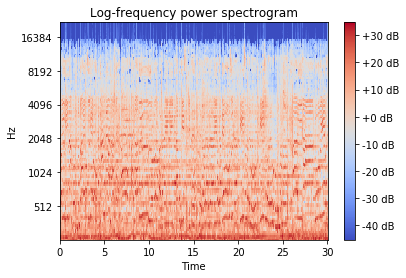

In [14]:
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels


class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration

# example(マリーゴールド)
x = read_as_melspectrogram(conf, "drive/My Drive/Colab Notebooks/spotify/input/tracks/2cKiHG16JBiqHdi7Llq0r7.mp3", trim_long_data=False, debug_display=True)

In [0]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def convert_wav_to_image(df, source, img_dest):
    X = []
    for i, row in tqdm(df.iterrows()):
        x = read_as_melspectrogram(conf, source/str(row.track_id + ".mp3"), trim_long_data=False)
        x_color = mono_to_color(x)
        X.append(x_color)
    return X

X_train = convert_wav_to_image(df, source=Path('drive/My Drive/Colab Notebooks/spotify/input/tracks/'), img_dest=Path('drive/My Drive/Colab Notebooks/spotify/input/track_mels/'))

1100it [18:12,  1.11s/it]


In [0]:
# save pickle
with open('drive/My Drive/Colab Notebooks/spotify/input/track_mels/track_mels.pickle', mode='wb') as f:
  pickle.dump(X_train, f)

### train
- refert to: https://www.kaggle.com/mhiro2/simple-2d-cnn-classifier-with-pytorch

In [0]:
# load pickle
with open('drive/My Drive/Colab Notebooks/spotify/input/track_mels/track_mels.pickle', mode='rb') as f:
  train_X = pickle.load(f)

In [17]:
# you must set gpu env.
torch.cuda.is_available()

True

In [0]:
# set all seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 2019
seed_everything(SEED)

In [0]:
# get jobs
N_JOBS = cpu_count()
os.environ['MKL_NUM_THREADS'] = str(N_JOBS)
os.environ['OMP_NUM_THREADS'] = str(N_JOBS)
DataLoader = partial(DataLoader, num_workers=N_JOBS)

In [0]:
# evaluate function
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

In [21]:
# get lables
labels = list(df.groupby("genre").count().index)
num_classes = len(labels)

# one-hot encoding
train_x = df[["track_id", "track_name", "genre"]]
train_y = pd.get_dummies(train_x, columns=["genre"]).drop(["track_id", "track_name"], axis=1)
display(train_y.head())

genre_acoustic  genre_ambient  ...  genre_techno  genre_trip-hop
0               1              0  ...             0               0
1               1              0  ...             0               0
2               1              0  ...             0               0
3               1              0  ...             0               0
4               1              0  ...             0               0

[5 rows x 11 columns]

In [0]:
class FATTrainDataset(Dataset):
    def __init__(self, mels, labels, transforms):
        super().__init__()
        self.mels = mels
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.mels)
    
    def __getitem__(self, idx):
        # crop 1sec
        image = Image.fromarray(self.mels[idx], mode='RGB')        
        time_dim, base_dim = image.size
        crop = random.randint(0, time_dim - base_dim)
        image = image.crop([crop, 0, crop + base_dim, base_dim])
        image = self.transforms(image).div_(255)

        label = self.labels[idx]
        label = torch.from_numpy(label).float()
        
        return image, label, idx

In [0]:
class FATTestDataset(Dataset):
    def __init__(self, fnames, mels, transforms, tta=5):
        super().__init__()
        self.fnames = fnames
        self.mels = mels
        self.transforms = transforms
        self.tta = tta
        
    def __len__(self):
        return len(self.fnames) * self.tta
    
    def __getitem__(self, idx):
        new_idx = idx % len(self.fnames)
        
        image = Image.fromarray(self.mels[new_idx], mode='RGB')
        time_dim, base_dim = image.size
        crop = random.randint(0, time_dim - base_dim)
        image = image.crop([crop, 0, crop + base_dim, base_dim])
        image = self.transforms(image).div_(255)

        fname = self.fnames[new_idx]
        
        return image, fname

In [0]:
transforms_dict = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
    ]),
}

In [0]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

In [0]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
        )

        self.linear = nn.Sequential(
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        lastlayer_output = self.fc(x)
        output = self.linear(lastlayer_output)
        return lastlayer_output, output

In [0]:
# load 
train_dataset = FATTrainDataset(train_X, train_y.values, transforms_dict['train'])
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
for x_batch, y_batch, idxs in train_loader:
  x = x_batch

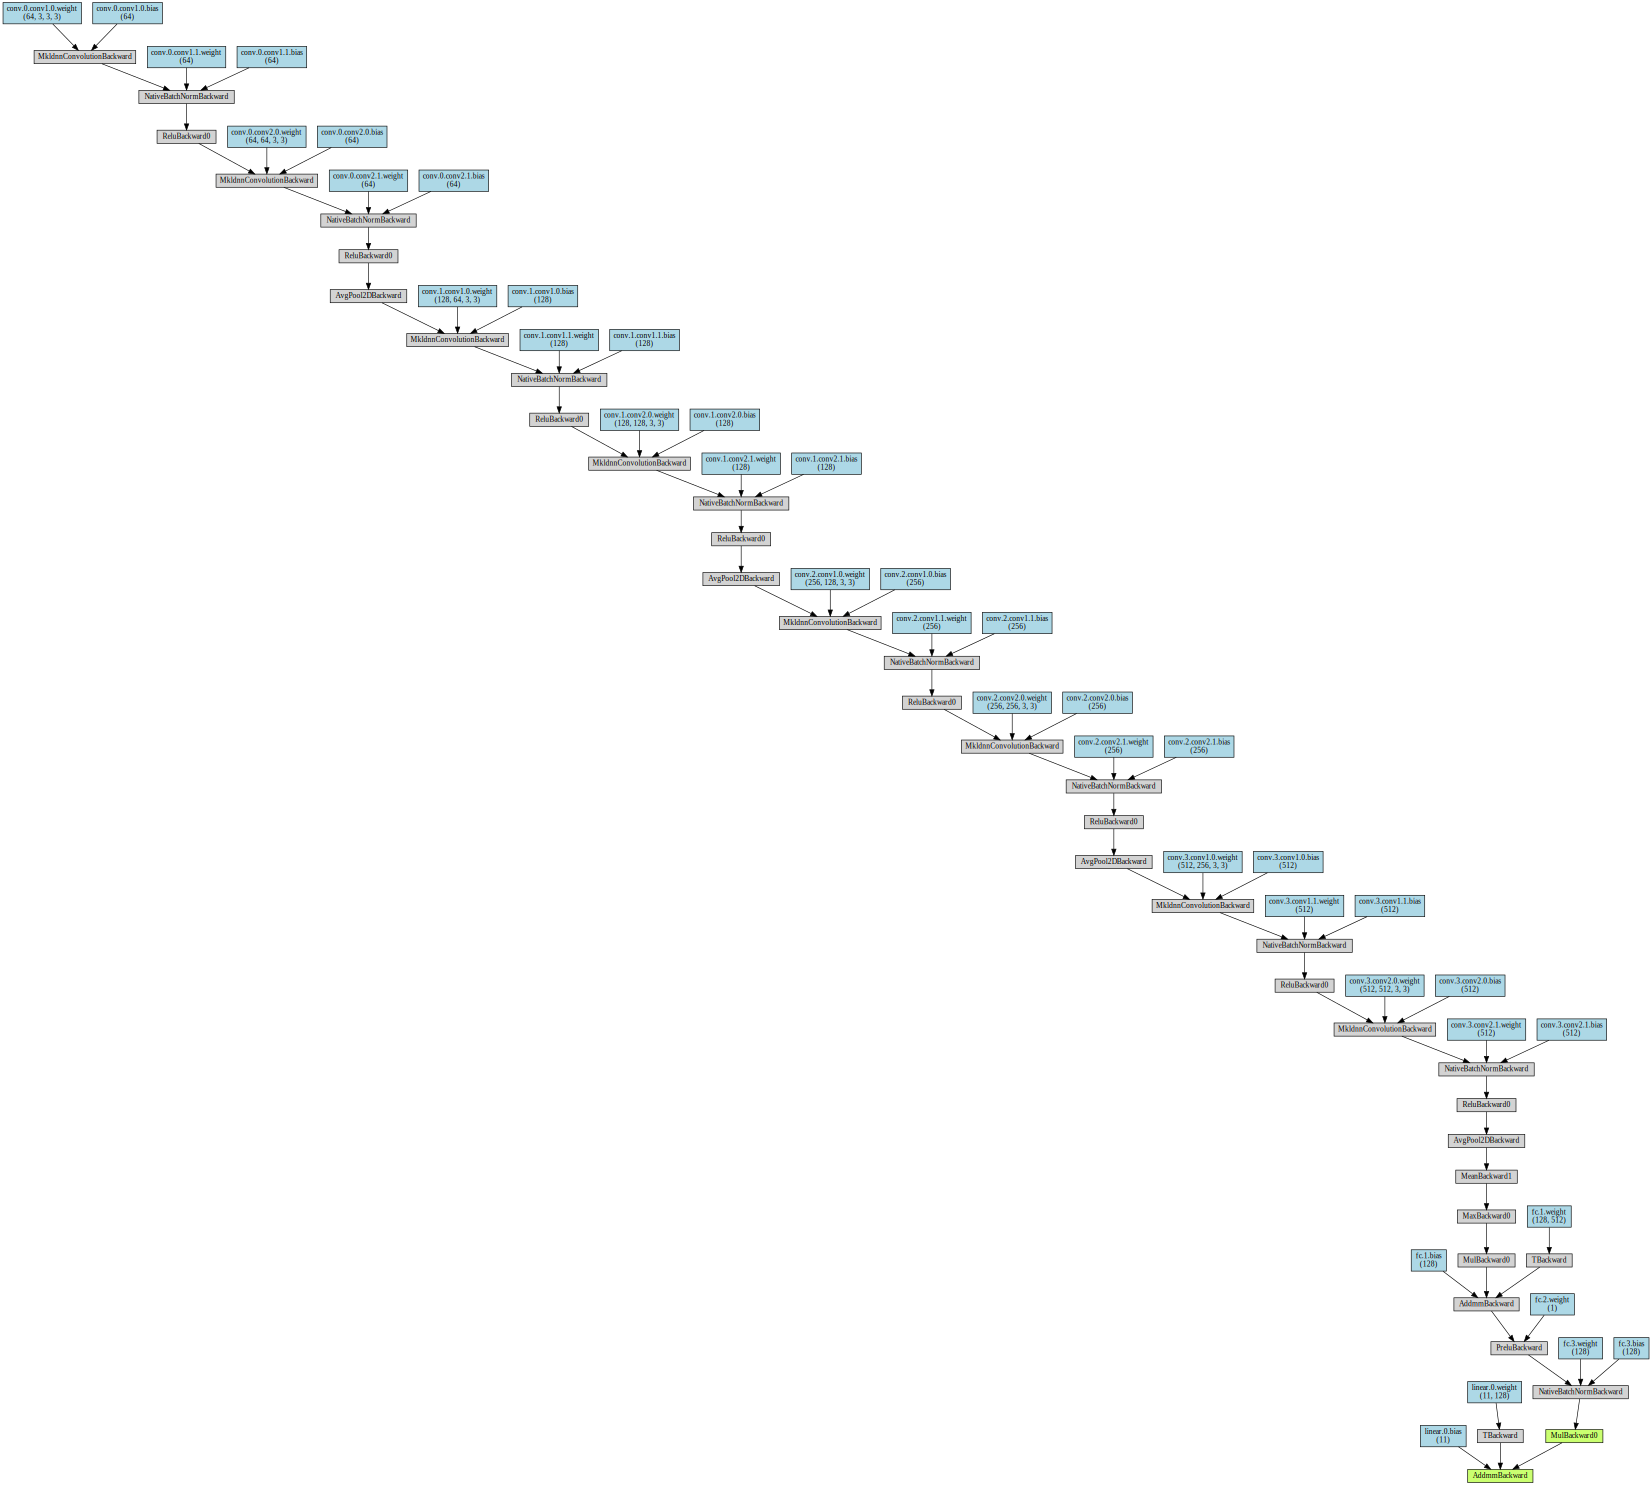

In [28]:
from torchviz import make_dot
model = Classifier(num_classes=num_classes)
make_dot(model(x), params=dict(model.named_parameters()))

In [0]:
def train_model(x_train, y_train, train_transforms):
    num_epochs = 80
    batch_size = 50
    test_batch_size = 100
    lr = 3e-3
    eta_min = 1e-5
    t_max = 10
    
    num_classes = y_train.shape[1]

    x_trn, x_val, y_trn, y_val, ind_t, ind_v = train_test_split(x_train, y_train, indices, test_size=0.2, random_state=SEED)
    
    train_dataset = FATTrainDataset(x_trn, y_trn, train_transforms)
    valid_dataset = FATTrainDataset(x_val, y_val, train_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, shuffle=False)

    model = Classifier(num_classes=num_classes).cuda()
    criterion = nn.BCEWithLogitsLoss().cuda()
    optimizer = Adam(params=model.parameters(), lr=lr, amsgrad=False)
    scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=eta_min)

    best_epoch = -1
    best_lwlrap = 0.
    mb = master_bar(range(num_epochs))
    for epoch in mb:
        start_time = time.time()
        model.train()
        avg_loss = 0.
        lastLayerOutputs = [0] * len(x_train) # 最終層の出力

        for x_batch, y_batch, idxs in progress_bar(train_loader, parent=mb):
            
            lastlayer_output, preds = model(x_batch.cuda())
            loss = criterion(preds, y_batch.cuda())

            # store lastlayer output
            for idx, lo in zip(idxs, lastlayer_output):
                lastLayerOutputs[ind_t[idx]] = lo

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_loss += loss.item() / len(train_loader)

        model.eval()
        valid_preds = np.zeros((len(x_val), num_classes))
        avg_val_loss = 0.

        for i, (x_batch, y_batch, idxs_valid) in enumerate(valid_loader):
            lastlayer_output, preds = model(x_batch.cuda())
            preds = preds.detach()
            loss = criterion(preds, y_batch.cuda())

            # store lastlayer output
            for idx_v, lo in zip(idxs_valid, lastlayer_output):
                lastLayerOutputs[ind_v[idx_v]] = lo

            preds = torch.sigmoid(preds)
            valid_preds[i * test_batch_size: (i+1) * test_batch_size] = preds.cpu().numpy()

            avg_val_loss += loss.item() / len(valid_loader)
            
        score, weight = calculate_per_class_lwlrap(y_val, valid_preds)
        lwlrap = (score * weight).sum()
        
        scheduler.step()

        if (epoch + 1) % 5 == 0:
            elapsed = time.time() - start_time
            mb.write(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  val_lwlrap: {lwlrap:.6f}  time: {elapsed:.0f}s')
    
        if lwlrap > best_lwlrap:
            best_epoch = epoch + 1
            best_lwlrap = lwlrap
            torch.save(model.state_dict(), 'drive/My Drive/Colab Notebooks/spotify/output/weight_best.pt')

            # save pickle
            with open('drive/My Drive/Colab Notebooks/spotify/output/lastlayer_output.pickle', mode='wb') as f:
                pickle.dump(lastLayerOutputs, f)
            
    return {
        'best_epoch': best_epoch,
        'best_lwlrap': best_lwlrap,
    }

In [39]:
result = train_model(train_X, train_y.values, transforms_dict['train'])

In [40]:
result

{'best_epoch': 71, 'best_lwlrap': 0.6319157483930211}

In [0]:
# load last layer output
with open('drive/My Drive/Colab Notebooks/spotify/output/lastlayer_output.pickle', mode='rb') as f:
  lastLayerOutput = pickle.load(f)

In [10]:
# 128次元
lastLayerOutput[0].shape

torch.Size([128])

## Visualize and Mapping

### visualize spotify's track feature

In [13]:
# normalize
df["loudness_norm"] = (df["loudness"] - df["loudness"].min()) / (df["loudness"].max() - df["loudness"].min())
df["tempo_norm"] = (df["tempo"] - df["tempo"].min()) / (df["tempo"].max() - df["tempo"].min())
df.head()

track_id  track_name  ... loudness_norm tempo_norm
0  2cKiHG16JBiqHdi7Llq0r7     マリーゴールド  ...      0.891141   0.400322
1  59eluCMn0XbOWqeWQ91FTM  君はロックを聴かない  ...      0.866781   0.362552
2  7GYGVDPbi0zQUBIkuOPAY0        ハルノヒ  ...      0.908046   0.405594
3  3u0e8pyoVc7l2u3T5thohY   空の青さを知る人よ  ...      0.920369   0.411888
4  6kKvmT4i0Dercz6f3kftg3      今夜このまま  ...      0.878275   0.392743

[5 rows x 34 columns]

In [14]:
track_feature_spotify = df[["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "loudness_norm", "tempo_norm"]].values
track_feature_spotify.shape

(1100, 9)

In [0]:
X_reduced = TSNE(n_components=2, random_state=42).fit_transform(track_feature_spotify)

In [47]:
# visualize
df["tsne_0"] = X_reduced[:, 0]
df["tsne_1"] = X_reduced[:, 1]
# df["tsne_2"] = X_reduced[:, 2]
fig = px.scatter(df, x='tsne_0', y='tsne_1', 
                 # z='tsne_2',
              color='genre', opacity=0.7, size_max=0.3, hover_data=["track_name"])
fig.show()

### visualize mels feature

In [0]:
lonpy = np.zeros((len(df), len(lastLayerOutput[0])))
for i in range(len(lastLayerOutput)):
  lonpy[i] = lastLayerOutput[i].cpu().detach().numpy()

In [0]:
reduced_mel = TSNE(n_components=2, random_state=42).fit_transform(lonpy)

In [55]:
# visualize
df["mel_0"] = reduced_mel[:, 0]
df["mel_1"] = reduced_mel[:, 1]
# df["tsne_2"] = X_reduced[:, 2]
fig = px.scatter(df, x='mel_0', y='mel_1', 
                 # z='tsne_2',
              color='genre', opacity=0.7, size_max=0.3, hover_data=["track_name"])
fig.show()

In [0]:
# calc cosine similarity
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [0]:
# calc all similarity
cos_matrix = []
cos_matrix = np.array([cos_sim(src, target) for target in track_feature_spotify for src in track_feature_spotify])

In [20]:
i = 0
max_indices_list = []
max_indices_cos_list = []
for i in tqdm(range(len(track_feature_spotify))):
  # 最大類似度のインデックスを取得
  cos_matrix_filterd = cos_matrix[i: (i + 1) * 1100]
  max_indices = np.argpartition(-cos_matrix_filterd, 10)[:10]
  max_indices_list.append(max_indices)
  max_indices_cos_list.append(cos_matrix_filterd[max_indices])

100%|██████████| 1100/1100 [00:11<00:00, 91.91it/s]


In [30]:
# 問い：マリーゴールドに似ている曲は？
df.iloc[max_indices_list[0]]

track_id  ... tempo_norm
705  278JqkBGkjDovOYAwE8TW7  ...   0.344490
702  2cKiHG16JBiqHdi7Llq0r7  ...   0.400322
394  33IOhptvC2Qoy2UhjiHXLV  ...   0.326091
17   0jWVUKsIoyo3zw64RaEWYg  ...   0.400322
0    2cKiHG16JBiqHdi7Llq0r7  ...   0.400322
804  278JqkBGkjDovOYAwE8TW7  ...   0.344490
663  5zNBixUKk94nh9vh7LBOLs  ...   0.381367
203  278JqkBGkjDovOYAwE8TW7  ...   0.344490
267  2gzApyJhCWVdTRxL9HB1EO  ...   0.302108
205  5LkWXxDxUTwEVHL0pfKL55  ...   0.313840

[10 rows x 34 columns]

In [0]:
# calc all similarity
cos_matrix_mel = []
cos_matrix_mel = np.array([cos_sim(src, target) for target in lonpy for src in lonpy])

In [21]:
i = 0
max_indices_list = []
max_indices_cos_list = []
for i in tqdm(range(len(track_feature_spotify))):
  # 最大類似度のインデックスを取得
  cos_matrix_filterd = cos_matrix_mel[i: (i + 1) * 1100]
  max_indices = np.argpartition(-cos_matrix_filterd, 10)[:10]
  max_indices_list.append(max_indices)
  max_indices_cos_list.append(cos_matrix_filterd[max_indices])

100%|██████████| 1100/1100 [00:08<00:00, 122.99it/s]


In [23]:
# 問い：マリーゴールドに似ている曲は？
df.iloc[max_indices_list[0]][["track_id", "track_name", "artist_name"]]

track_id    track_name   artist_name
631  5U1xJmlRimUm6DtRd0kM6f         さくらんぼ     Ai Otsuka
21   0nvvaKnWZABiknO5fcRifn             葵        Aimyon
613  3mj7vEw5A8MQ35p8wFLvZc           黒い羊  Keyakizaka46
34   1i6F01jxN0Qy7xFk3EldRO         プレゼント        Aimyon
0    2cKiHG16JBiqHdi7Llq0r7       マリーゴールド        Aimyon
606  7e8IV4U2LdP7p7uJ83EZmh  帰り道は遠回りしたくなる    Nogizaka46
657  3ZKTwPyVDoDh8vRvyBcXvV   やさしさで溢れるように        Flower
17   0jWVUKsIoyo3zw64RaEWYg       マリーゴールド        Aimyon
781  2tgWF9EZzqiq4Qzdzeow1A        ら、のはなし        Aimyon
686  57ZCBEDn2ziqdKlBT7FJIO    僕のこと、知ってる?    Nogizaka46